# Speckle Tracking Examples for Single Pairs of Synthetic Data

This notebook is designed to illustrate how synthetic data is generated and to demonstrate the shape of the cross-correlation functions for various variants on speckle tracking (i.e., complex vs amplitude matching, no prior oversampling vs 2x oversampling, and peak oversampling with and without a Gaussian fit).

## Generating Synthetic Data

Speckle for pairs of SAR images, particularly for featureless areas, can essentially be modeled as correlated pairs of spectrally white, complex, Gaussian random variables. Thus, if we have two uncorrelated images, $X$ and $Z$, a pair of correlated images ($X$ and $Y$) with correlation coefficient, $\rho$ can be generated as: $$X=X$$ and $$Y = \alpha X + (1-\alpha) Z$$ where $$\gamma = \frac{\rho^2}{2 \rho^2 - 1}$$ and $$\alpha = \gamma - \text{sgn}(\alpha) \sqrt{\gamma^2 - \gamma}$$

To create sub-pixel shifted pairs, $Y$ can forward Fourier transformed, the spectra can be zero padded by a factor N, and then inverse transformed. A shifted version of $Y$ ($Y_{\delta_r\delta_c}$) can then be extracted with appropriate indexing of the oversampled array. In this case, the row and columns shifts ($\delta_r$ and $\delta_c$) must be in increments of $N^{-1}$.

## Supporting Code

The results in this notebook make use of a supporting set of python functions that can be found at: https://github.com/fastice/nisarfunc. To install, go to a directory in your Python path (if you haven't set a Python path you will need to; google "setting python path".) The necesary functions are then imported as:

In [10]:
import nisarfunc as nf

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The results in this notebook make use of a supporting set of python functions that can be found at: https://github.com/fastice/nisarfunc. To install, go to a directory in your Python path (if you haven't set a Python path you will need to; google "setting python path".) The necesary functions are then imported as:

## Synthetic Data Examples

The following examples illustrate the generation of the synthetic data and cross correlation of the results. 

### Plot Routine

Before presenting the examples, the code below will plot the correlation peaks.

In [12]:
def plotPeaks(cc, ccPeak, overSampleFactor, title, overSample=False, gaussPeak=None):
    fig, myAxes = plt.subplots(2,2,figsize=(10,5))  # Setup figure
    fig.suptitle(title, fontsize=14)
    # Compute x for plots
    xp = np.arange(-ccPeak.shape[0] / 2, ccPeak.shape[0] / 2)/overSampleFactor
    x = np.arange(-cc.shape[0]/2, cc.shape[0]/2)
    if overSample:
        x, xp = x/2, xp/2
    # Show peaks
    myAxes[0,0].imshow(np.abs(cc), extent=[min(x), max(x), min(x), max(x)])
    myAxes[1,0].imshow(np.abs(ccPeak), extent=[min(xp), max(xp), min(xp), max(xp)])
    # Plot cuts through peaks. 
    r,c = np.unravel_index(np.argmax(cc), cc.shape)  # Locate peak
    myAxes[0,1].plot(x, np.real(cc[r,:]),'r-', marker='*', label='column (real)')
    myAxes[0,1].plot(x, np.real(cc[:,c]),'b-',marker='*', label='row (real)')
    r1,c1 = np.unravel_index(np.argmax(ccPeak), ccPeak.shape)  # Locate oversampled peak
    myAxes[1,1].plot(xp, np.real(ccPeak[r1,:],),'r.', label='column')
    myAxes[1,1].plot(xp, np.real(ccPeak[:,c1]),'b.', label='row')
    if gaussPeak is not None:
        myAxes[1,1].plot(xp, np.real(gaussPeak[r1,:],),'k',linewidth=0.5, label='Gauss Fit')
        myAxes[1,1].plot(xp, np.real(gaussPeak[:,c1]),'k', linewidth=0.5, label='Gauss Fit') 
    # Add legends
    myAxes[0,1].legend()
    myAxes[1,1].legend()
    # label axes and set limits
    for myAxis, xlab, ylab in zip(myAxes.flatten(),['row (pixels)', 'r/c pixels']*2,
                                  ['col (pixels)', 'rho'] * 2):
        myAxis.set_xlabel(xlab, fontSize=14)
        myAxis.set_ylabel(ylab, fontSize=14)
        myAxis.set_xlim([-10,10])
        if 'rho' not in ylab:
            myAxis.set_ylim([-10,10])
    fig.tight_layout(rect=[0,0.03,1,0.95])
    return fig, myAxes

### Correlated Patches

Several of the parameters, such as the cross correlation, $\rho$, are set here so that the same result is shown for all the different matching examples. A single set of patches is used so that results can be compared across methods. Note each time the notebook runs, and different random sample will be created. Many of the parameters are defined below.
    

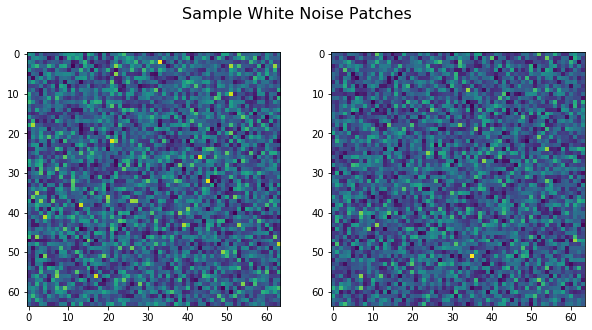

In [13]:
rho = 0.5  # Complex correlation
deltaR, deltaC = 3, 5  # row and column shifts (deltaR/overSample and deltaC/overSample pixels)
overSampleFactor = 8  # Oversample factor used to simulate patches
nr, nc = 64, 64
osPeak, osBox = 20, 4  # Parameters used to oversample the peak
gaussReduce = 2
X, Yrc = nf.correlatedShiftedPatches(nr, nc, deltaR, deltaC, rho, overSample=overSampleFactor, sigma=1.0)
fig, myAxes = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Sample White Noise Patches', fontsize=16)
myAxes[0].imshow(np.abs(X))
myAxes[1].imshow(np.abs(Yrc))

### Simulation

The following block of code will perform cross correlation on the above patches, with the following parameters:

    ampMatch: True for amplitude matching, False for complex matching.
    overSample: Apply 2x oversampling to patches before correlating.
    rho: Correlation used to create patch (info only).
    deltaR, deltaC:  Pixel shift for second image (subpixel offsets is deltaR/overSampleFactor (info only).
    overSampleFactor: Oversample factor used to generate patches (info only).
    osPeak:  How much to oversample area around peak for sinc interpolation (same factor with/without overSample).
    osBox: How big an area around the peak to sample (will be scaled by 2 for overSample==True, so same area sampled).
    gaussReduce: Will reduce overSampleFactor (i.e., oversampleFactor/gauseReduce) since fit partially compensates for posting loss.

In [14]:
def runSim(ampMatch, overSample, rho, deltaR, deltaC, overSampleFactor, osPeak, osBox, gaussReduce=4):
    dr, dc, cmax, cc, ccPeak = nf.nccPatches(X, Yrc,subPixArgs=(osPeak, osBox),overSampleCorr=overSample, ampMatch=ampMatch)
    dr1, dc1, cmax1, cc, ccPeak1 = nf.nccPatches(X, Yrc,subPixArgs=(int(osPeak/gaussReduce), osBox),overSampleCorr=overSample, ampMatch=ampMatch,
                                                subPix=nf.osSubPixGaussian)
    if np.isfinite(dr1):
        _,_,_, myGauss = nf.gaussFit(np.real(ccPeak), osPeak/4, debug=True)
        print(f'OS error {dr - deltaR / overSampleFactor:0.3f}, {dc - deltaC / overSampleFactor:0.3f}')
        print(f'Gauss error {dr1 - deltaR / overSampleFactor:0.3f}, {dc1 - deltaC / overSampleFactor:0.3f}')
        fig, myAxes = plotPeaks(cc, ccPeak, overSampleFactor,
                                f'ampMatch={ampMatch}, overSample={overSample}, rho={rho:0.3f}, overSampleFactor={overSample}, '
                                f'osPeak={osPeak}, osBox={osBox}, gaussReduce={gaussReduce}',
                                overSample=overSample, gaussPeak=myGauss)
    else:
        print('No valid match return - result to noisy')

### Normalized Complex Cross Correlation: No Oversampling

Images can be cross correlated using FFT based methods (see FFT notebook). This example plots the cross correlation for the non-oversampled case. In this and the following examples, the peaks are as the extracted and oversampled. 

OS error -0.025, 0.025
Gauss error 0.043, 0.059


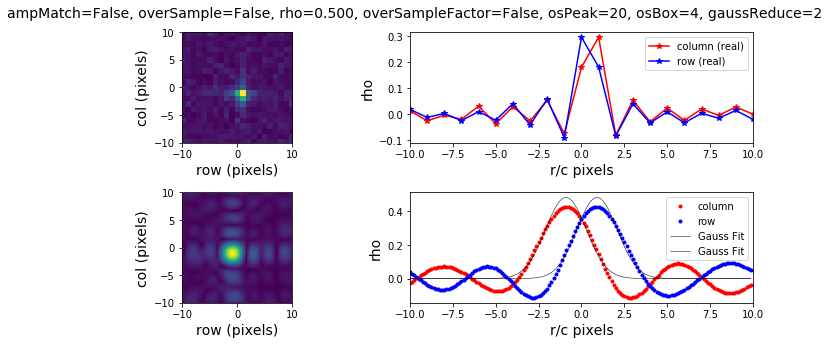

In [15]:
ampMatch, overSample = False, False
runSim(ampMatch, overSample, rho, deltaR, deltaC, overSampleFactor, osPeak, osBox, gaussReduce=gaussReduce)

### Normalized Complex Cross Correlation: 2x Oversampling

Images can be cross correlated using FFT based methods (see FFT notebook). This example plots the cross correlation for the non-oversampled case. 

OS error 0.000, 0.000
Gauss error 0.026, 0.024


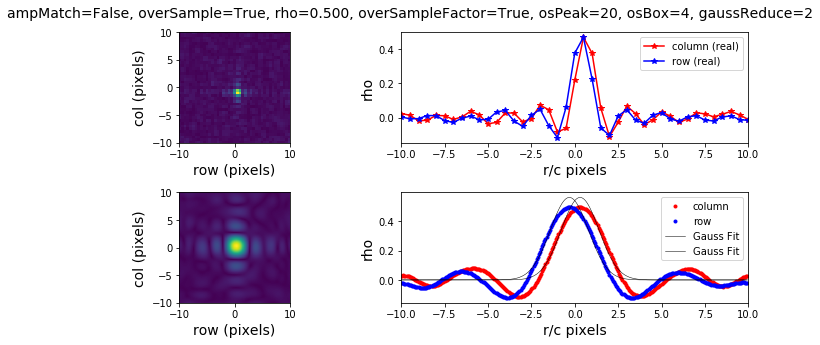

In [16]:
ampMatch, overSample = False, True
runSim(ampMatch, overSample, rho, deltaR, deltaC, overSampleFactor, osPeak, osBox, gaussReduce=gaussReduce)

### Normalized Amplitude Cross Correlation: No Oversampling

Images can be cross correlated using FFT based methods (see FFT notebook). This example plots amplitude cross correlation for the non-oversampled case. 

OS error -0.075, 0.375
Gauss error 0.019, 0.416


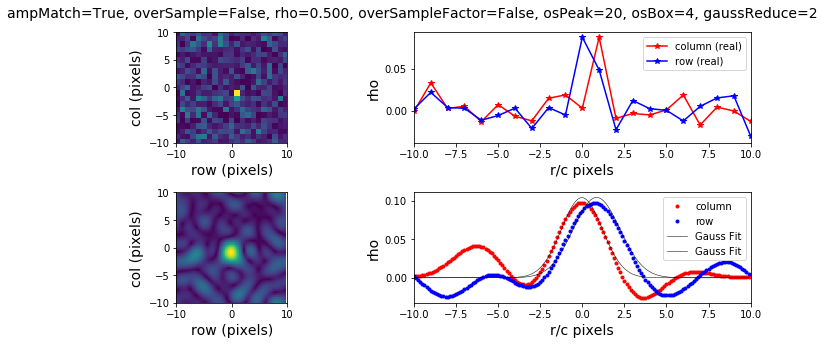

In [17]:
ampMatch, overSample = True, False
runSim(ampMatch, overSample, rho, deltaR, deltaC, overSampleFactor, osPeak, osBox, gaussReduce=gaussReduce)

### Normalized Amplitude Cross Correlation: 2x Oversampling

Images can be cross correlated using FFT based methods (see FFT notebook). This example plots amplitude cross correlation for the 2x-oversampled case. 

OS error 0.000, 0.000
Gauss error 0.033, 0.037


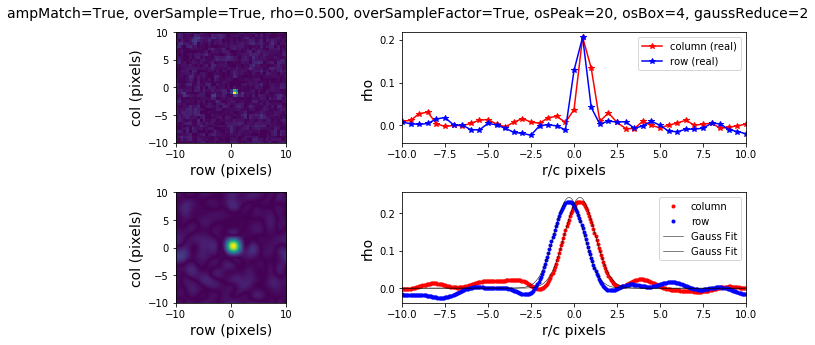

In [18]:
ampMatch, overSample = True, True
runSim(ampMatch, overSample, rho, deltaR, deltaC, overSampleFactor, osPeak, osBox, gaussReduce=gaussReduce)

## Conclusions

The results shown here are consistent with the simulations in the complex and amplitude matching notebooks. In particular:
* While there is a slight improvement when 2x oversampling is used for complex matching, that improvement is not immediatly obvious in the shape of the correlation functions. At most, the 2x peaks appear subjectively to be slightly sharper. 

* For amplitude matching the peaks are not as high for this reasonably well correlated case ($\rho=0.5$), but the side lobes are much smaller, which may illustrate why the amplitude peaks are more finally resolved (see amplitude matching notebook).

* For amplitude matching the comparsion of no oversampling vs 2x oversampling are immediately obvious. The 2x-oversampled amplitude example has a nice sharp peak against a low-noise background. By constrast, amplitude case with no oversampling has a weak peak with lots of background noise. Along with the data in the amplitude matching notebook, the results indicate 2x oversampling should always be applied for amplitude matching.
* The Gaussian fits are meant to illustrate how well they fit the data. Since the notebook only runs one sample at a time, they do not illustrate which method might be better (see other speckle tracking notebooks).